# Kaggle Recipes Parsing

In [1]:
import pandas as pd
import numpy as np
import os
import collections
import gensim
import nltk
nltk.download('punkt')
from gensim.models import word2vec, phrases
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, \
            strip_non_alphanum, strip_multiple_whitespaces, strip_short

import textblob
from textblob import TextBlob, Word

import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn

%matplotlib inline

[nltk_data] Downloading package punkt to /home/mbarbari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Recipe Data Loading

In [2]:
filepath = f"{os.getcwd()}/data/recipes.csv"

df_recipes = pd.read_csv(filepath, encoding="ISO-8859-1")
df_recipes

,id,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients
0,Southern-Cornbread-Dressing-1357820,Southern Cornbread Dressing,4.0,3600.0,NaN,[Southern & Soul Food],"[buttermilk cornbread, sandwich bread, salt, b..."
1,Peanut-butter-fudge-297693,Peanut Butter Fudge,4.0,8100.0,[Desserts],[American],"[Country Crock® Spread, light corn syrup, crea..."
2,Buckeyes-298471,Buckeyes,4.0,6600.0,[Desserts],[American],"[Skippy® Super Chunk® Peanut Butter, Country C..."
3,Disappearing-buffalo-chicken-dip-297712,Disappearing Buffalo Chicken Dip,4.0,2100.0,[Appetizers],[American],"[light mayonnaise, lemon juice, cayenne pepper..."
4,Classic-macaroni-salad-304692,Classic Macaroni Salad,4.0,1500.0,"[Salads, Side Dishes]",[American],"[elbow macaroni, hellmann' or best food real m..."
...,...,...,...,...,...,...,...
5470,Miso-Soup-1225759,Miso Soup,4.0,600.0,[Soups],[Japanese],"[dashi, miso, silken tofu, wakame, green onion..."
5471,Miso-Marinated-Pork-_butaniku-no-misozuke_-751346,Miso Marinated Pork (butaniku no misozuke),4.0,2400.0,[Main Dishes],[Japanese],"[pork cutlets, white miso, red miso, fresh gin..."
5472,Japanese-Street-Food-Recipe---Chicken-Karaage-...,Japanese Street Food Recipe - Chicken Karaage,4.0,2700.0,[Main Dishes],"[Japanese, Asian]","[chicken legs, sake, soy sauce, ginger, potato..."
5473,Ponzu-MyRecipes-265663,Ponzu,4.0,600.0,[Condiments and Sauces],"[Japanese, Asian]","[green onions, fresh lemon juice, mirin, lower..."


### Recipe Data Cleanup

In [3]:
df_recipes.isna().sum()

id                      0
recipeName              0
rating                  1
totalTimeInSeconds    235
course                492
cuisine                 1
ingredients             1
dtype: int64

In [4]:
df_recipes.dropna(subset=['cuisine', 'ingredients'], inplace=True)
df_recipes

,id,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients
0,Southern-Cornbread-Dressing-1357820,Southern Cornbread Dressing,4.0,3600.0,NaN,[Southern & Soul Food],"[buttermilk cornbread, sandwich bread, salt, b..."
1,Peanut-butter-fudge-297693,Peanut Butter Fudge,4.0,8100.0,[Desserts],[American],"[Country Crock® Spread, light corn syrup, crea..."
2,Buckeyes-298471,Buckeyes,4.0,6600.0,[Desserts],[American],"[Skippy® Super Chunk® Peanut Butter, Country C..."
3,Disappearing-buffalo-chicken-dip-297712,Disappearing Buffalo Chicken Dip,4.0,2100.0,[Appetizers],[American],"[light mayonnaise, lemon juice, cayenne pepper..."
4,Classic-macaroni-salad-304692,Classic Macaroni Salad,4.0,1500.0,"[Salads, Side Dishes]",[American],"[elbow macaroni, hellmann' or best food real m..."
...,...,...,...,...,...,...,...
5469,Chicken-Teriyaki-573526,Chicken Teriyaki,4.0,2700.0,[Main Dishes],[Japanese],"[chicken thighs, light soy sauce, mirin, sake,..."
5470,Miso-Soup-1225759,Miso Soup,4.0,600.0,[Soups],[Japanese],"[dashi, miso, silken tofu, wakame, green onion..."
5471,Miso-Marinated-Pork-_butaniku-no-misozuke_-751346,Miso Marinated Pork (butaniku no misozuke),4.0,2400.0,[Main Dishes],[Japanese],"[pork cutlets, white miso, red miso, fresh gin..."
5472,Japanese-Street-Food-Recipe---Chicken-Karaage-...,Japanese Street Food Recipe - Chicken Karaage,4.0,2700.0,[Main Dishes],"[Japanese, Asian]","[chicken legs, sake, soy sauce, ginger, potato..."


### Ingredient parsing

In [5]:
df_recipes['ingredients'] = df_recipes['ingredients'].apply(lambda x: x.lower())
df_recipes['ingredients']

0       [buttermilk cornbread, sandwich bread, salt, b...
1       [country crock® spread, light corn syrup, crea...
2       [skippy® super chunk® peanut butter, country c...
3       [light mayonnaise, lemon juice, cayenne pepper...
4       [elbow macaroni, hellmann' or best food real m...
                              ...                        
5469    [chicken thighs, light soy sauce, mirin, sake,...
5470    [dashi, miso, silken tofu, wakame, green onion...
5471    [pork cutlets, white miso, red miso, fresh gin...
5472    [chicken legs, sake, soy sauce, ginger, potato...
5473    [green onions, fresh lemon juice, mirin, lower...
Name: ingredients, Length: 5474, dtype: object

In [6]:
def preprocess_ingredient(ingredient : str) -> str:
    ing = remove_stopwords(ingredient)
    ing = strip_numeric(ingredient)
    ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground','',ing).strip()
    ing = strip_short(ing,2)
    ing = strip_multiple_whitespaces(ing)
    ing = strip_punctuation(ing)
    ing = strip_non_alphanum(ing)
    
    #convert plurals to singular e.g. tomatoes --> tomato
    ing = (" ".join(TextBlob(ing).words.singularize()))
    return ing


In [7]:
total_ingredients = []
all_recipes_ingredients = []

for i in range(len(df_recipes)):
    all_ingredients = list()

    ingredient_string = df_recipes.loc[i, "ingredients"][1:-1]

    for ingredient in ingredient_string.split(','):
        processed_ingredient = preprocess_ingredient(ingredient)
        all_ingredients.append(processed_ingredient)
        total_ingredients.append(processed_ingredient)

    all_recipes_ingredients.append(all_ingredients)

In [8]:
counts_ingr = collections.Counter(total_ingredients)

print(f"Total Ingredients {total_ingredients}")
print(f"Unique Ingredients {len(counts_ingr.values())}")
print(f"Total Recipes {len(all_recipes_ingredients)}")

Total Ingredients ['buttermilk cornbread', 'sandwich bread', 'salt', 'black pepper', 'sage', 'egg', 'onion', 'celery', 'butter', 'cream of chicken soup', 'chicken stock', 'country crock spread', 'light corn syrup', 'creamy peanut butter', 'confectioner sugar', 'vanilla extract', 'skippy super chunk peanut butter', 'country crock spread', 'confectioner sugar', 'semi sweet chocolate morsel', 'light mayonnaise', 'lemon juice', 'cayenne pepper sauce', 'blue cheese', 'chive', 'dar cheese', 'chicken', 'elbow macaroni', 'hellmann or best food real mayonnai', 'vinegar white white', 'wine', '', 'hellmann s dijonnaise creamy dijon mustard', 'sugar', 'salt', 'black pepper', 'celery', 'bell pepper', 'slouse', 'onion', 'hellmann or best food real mayonnai', 'lemon juice', 'sugar', 'salt', 'cabbage', 'carrot', 'bell pepper', 'fat milk', 'butter', 'flmy', 'fine sea salt', 'black pepper', 'nutmeg', 'skippy creamy peanut butter', 'sugar', 'cream cheese', 'topping', 'hot fudge topping', 'inch chocolate 

In [9]:
df_recipes['clean_ingredients'] = pd.Series(all_recipes_ingredients)

df_recipes['ingredient_count'] = df_recipes.apply(lambda row: len(row['clean_ingredients']), axis=1)

df_recipes['time_mins'] = df_recipes.totalTimeInSeconds.apply(lambda x : x/60)
df_recipes

,id,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients,clean_ingredients,ingredient_count,time_mins
0,Southern-Cornbread-Dressing-1357820,Southern Cornbread Dressing,4.0,3600.0,NaN,[Southern & Soul Food],"[buttermilk cornbread, sandwich bread, salt, b...","[buttermilk cornbread, sandwich bread, salt, b...",11,60.0
1,Peanut-butter-fudge-297693,Peanut Butter Fudge,4.0,8100.0,[Desserts],[American],"[country crock® spread, light corn syrup, crea...","[country crock spread, light corn syrup, cream...",5,135.0
2,Buckeyes-298471,Buckeyes,4.0,6600.0,[Desserts],[American],"[skippy® super chunk® peanut butter, country c...","[skippy super chunk peanut butter, country cro...",4,110.0
3,Disappearing-buffalo-chicken-dip-297712,Disappearing Buffalo Chicken Dip,4.0,2100.0,[Appetizers],[American],"[light mayonnaise, lemon juice, cayenne pepper...","[light mayonnaise, lemon juice, cayenne pepper...",7,35.0
4,Classic-macaroni-salad-304692,Classic Macaroni Salad,4.0,1500.0,"[Salads, Side Dishes]",[American],"[elbow macaroni, hellmann' or best food real m...","[elbow macaroni, hellmann or best food real ma...",13,25.0
...,...,...,...,...,...,...,...,...,...,...
5469,Chicken-Teriyaki-573526,Chicken Teriyaki,4.0,2700.0,[Main Dishes],[Japanese],"[chicken thighs, light soy sauce, mirin, sake,...","[chicken thigh, light soy sauce, mirin, sake, ...",6,45.0
5470,Miso-Soup-1225759,Miso Soup,4.0,600.0,[Soups],[Japanese],"[dashi, miso, silken tofu, wakame, green onion...","[dashi, miso, silken tofu, wakame, onion, water]",6,10.0
5471,Miso-Marinated-Pork-_butaniku-no-misozuke_-751346,Miso Marinated Pork (butaniku no misozuke),4.0,2400.0,[Main Dishes],[Japanese],"[pork cutlets, white miso, red miso, fresh gin...","[pork cutlet, white miso, miso, ginger, sake, ...",6,40.0
5472,Japanese-Street-Food-Recipe---Chicken-Karaage-...,Japanese Street Food Recipe - Chicken Karaage,4.0,2700.0,[Main Dishes],"[Japanese, Asian]","[chicken legs, sake, soy sauce, ginger, potato...","[chicken leg, sake, soy sauce, ginger, potato ...",8,45.0


In [10]:
print(np.mean(list(counts_ingr.values())))
print(np.std(list(counts_ingr.values())))
print(np.median(list(counts_ingr.values())))
print(np.percentile(list(counts_ingr.values()), [25., 50., 75., 99.]))

20.7177267595032
98.59145809722263
2.0
[  1.     2.     7.   362.44]


In [11]:
print("Most Common Ingredients")
print(counts_ingr.most_common(10))

print("Least Common Ingredients")
print(counts_ingr.most_common()[-10:])

Most Common Ingredients
[('salt', 2377), ('onion', 1794), ('garlic', 1484), ('pepper', 1208), ('butter', 1160), ('black pepper', 1020), ('sugar', 1019), ('olive oil', 897), ('water', 881), ('egg', 845)]
Least Common Ingredients
[('orecchiette', 1), ('gorgonzola', 1), ('ciabattum bun', 1), ('bertolli', 1), ('liquid egg substitute', 1), ('delallo extra virgin olive oil', 1), ('sourdough baguette', 1), ('mentsuyu', 1), ('canola oil cooking spray', 1), ('wakame', 1)]


### Word Visualization

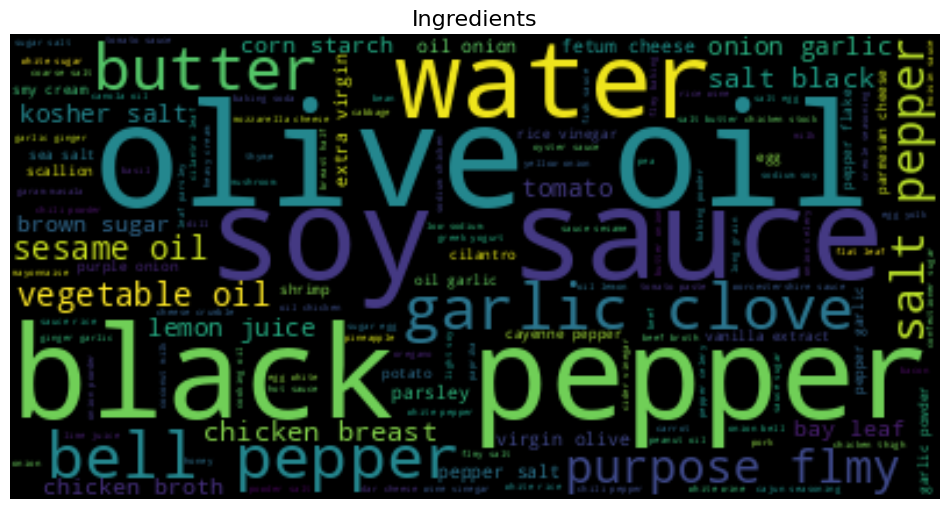

In [12]:
from wordcloud import WordCloud

def plot_wordcloud(text, title=None, max=1000, size=(12,8), title_size=16):
    wordcloud = WordCloud(max_words=max).generate(text)
    plt.figure(figsize=size)
    plt.title(title, size=title_size)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


plot_wordcloud(' '.join(total_ingredients), title='Ingredients')

### Word2Vec Training

In [14]:
num_features = 300
min_word_count = 4
num_workers = 4
context = 10

downsampling = 1e-2

model = word2vec.Word2Vec(all_recipes_ingredients, workers=num_workers, \
            vector_size=num_features, min_count = min_word_count, \
            window = context,sample = downsampling, epochs=20)


TypeError: Word2Vec.__init__() got an unexpected keyword argument 'iter'